In [1]:
import re
#import wget
import time
import nltk
import keras
import zipfile
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import SimpleRNN,Dense,LSTM,Dropout,GRU,Bidirectional
from keras import regularizers


import sys
np.set_printoptions(threshold=sys.maxsize)
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Only include classes specified in accepted_class 
def clean_class(df,accepted_class:np.ndarray):
   # accepted_class = np.array([1, 0, -1])
    decode_map = {0: 0, 2: 2, 1: 1,-1:-1, '0': 0, '2': 2, '1': 1,'-1':-1}
    df['target'].map(decode_map)
    df = df.loc[df['target'].isin(accepted_class)]
    df.astype({'target': 'int'}).dtypes
    return df

In [3]:
def preprocess_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    # removing tags and text inside tags Eg: <a> , <e>
    text = re.sub(r'<[^>]*>','',text)
    # removing Http Links
    text = re.sub(r'https?:\S+','',text)
    # removing special characters
    text = re.sub(r'[^\w\s]','',text)
   # text = re.sub(r'[0-9]+','',text)
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) 
    text = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in text.split())
    return text.strip()

In [4]:
def load_glove_embeddings():
#     if not path.exists('glove.twitter.27B.zip'):
#         print('Please wait while the Global Vector Word Embeddings are being downloaded.')
#         !wget 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
#    glove = zipfile.ZipFile('glove.twitter.27B.zip')
    embeddings = {}
    with open('../input/glovetwitter/glove.twitter.27B.200d.txt','r') as file:
        for line in file:
#             line = line.decode('utf-8')
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            embeddings[word] = word_vectors
    return embeddings


In [5]:
def generate_embeddings(tokenizer):
    vocab_size = len(tokenizer.word_index)+1
    embedding_size = 200
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    for word,index in tokenizer.word_index.items():
        vector = word_embeddings.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
    return embedding_matrix

In [6]:
# def read_input():
#     if not path.exists('training-Obama-Romney-tweets.rar'):
#         print('Downloading training-Obama-Romney-tweets.rar')
#         wget.download('https://www.cs.uic.edu/~liub/teach/cs583-fall-20/training-Obama-Romney-tweets.rar')
#     rar = rarfile.RarFile('training-Obama-Romney-tweets.rar')
#     input =rar.open('training-Obama-Romney-tweets.xlsx')
#     return input

In [7]:
def clean_excel(data:pd.DataFrame):
    # Preprocessing Training data
    # Removing first row as it has only information about class value mappings
    data = data[1:]
    data.rename(columns={'Unnamed: 4': 'target'}, inplace=True)
    # Dropping empty columns
    data.dropna(how='all', inplace=True, axis=1)
    #Dropping date and time
    data.dropna(subset=['Anootated tweet','target'] ,inplace=True, axis=0)
    return data

In [8]:
def prediction_labels(pred_labels):
    l=np.argmax(pred_labels,axis=1)
    l = np.where(l==0,-1,l)
    l = np.where(l==1,0,l)
    l = np.where(l==2,1,l)
    return l

In [9]:
# Function to plot the Accuracy and Loss of the training and testing models

def generate_plot(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model Accuracy (Train & Validation)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss(Train & Validation)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def split_train_test(data,flag):
    if(flag):
        #Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(data['Anootated tweet'],data_clean['target'], test_size=0.2, stratify=data_clean['target'])
        return X_train, X_test, y_train, y_test
    else :
        return 0

def tokenize(data):
    tokenizer = Tokenizer(num_words=20000,oov_token='<OOV>')
    tokenizer.fit_on_texts(data)
    return tokenizer


#https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm,classes):
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

    
def evaluate_test_data(model,y_test,x_test_processed):
    print("Test data evaluation")
    model.evaluate(x_test_processed,pd.get_dummies(y_test))
    test_pred_labels = model.predict(x_test_processed)
    test_pred_labels =prediction_labels(test_pred_labels)
    classes = unique_labels(test_pred_labels,y_test.astype(int))
    print("Ytest ")
    print(y_test.value_counts())
    print("Pred ")
    print(pd.Series(test_pred_labels).value_counts())
    cf =confusion_matrix(y_test.astype(int),test_pred_labels,classes)
    print(cf)
    print(classification_report(y_test.astype(int),test_pred_labels))
    plot_confusion_matrix(cf,classes)
    return test_pred_labels
    
    

# Returns trained model and pred_labels for test data only if train_on_all_data=False 
def train_evaluate_model(**kwargs):
    
    data=kwargs['data']
    model_type = kwargs['model_type']
    input_len = kwargs['input_length']
    model_units = kwargs['model_units']
    epochs = kwargs['epochs']
    learning_rate = kwargs['learning_rate']
    train_on_all_data = kwargs['train_on_all_data']
    
    if(not train_on_all_data):
        #Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = split_train_test(data,not train_on_all_data)
        tokenizer = tokenize(X_train)
        word_embedding_matrix = generate_embeddings(tokenizer)
        X_train_processed = tokenizer.texts_to_sequences(X_train)
        X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')
        X_test_processed = tokenizer.texts_to_sequences(X_test)
        X_test_processed = pad_sequences(X_test_processed, padding='post', maxlen=50,truncating='pre')
    else:
        tokenizer = tokenize(data['Anootated tweet'])
        word_embedding_matrix = generate_embeddings(tokenizer)
        X_train_processed = tokenizer.texts_to_sequences(data['Anootated tweet'])
        X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')
 
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index) + 1, 200, weights=[word_embedding_matrix], input_length=input_len,
                                trainable=False, mask_zero=True)
    model.add(embedding_layer)
    if kwargs['model_type'] == 'rnn':
        model.add(SimpleRNN(model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
    elif kwargs['model_type'] == 'lstm':
        model.add(LSTM(units=model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
    elif kwargs['model_type'] == 'gru':
        model.add(GRU(units=model_units,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    else:
        model.add(Bidirectional(LSTM(units=model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01))))
    
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    dot_img_file = 'model_1.png'
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    model_history = model.fit(X_train_processed, pd.get_dummies(y_train), batch_size=128, epochs=epochs, verbose=1, validation_split=0.2)
    plot = generate_plot(model_history)
    if(not train_on_all_data):
        test_pred_labels = evaluate_test_data(model,y_test,X_test_processed)
        return model,test_pred_labels
    else :
        return model

In [10]:
#Load Glove vectors
word_embeddings = load_glove_embeddings()

In [11]:
#Read data from all the sheets
sheets = [0,1]
input_data = pd.read_excel('../input/cs583-dataset/training-Obama-Romney-tweets.xlsx',sheet_name=sheets)

In [12]:
#Clean excel remove unecessary rows and emtpy columns 
data_clean = pd.DataFrame()
for i in sheets:
    data_temp = clean_excel(input_data[i])
    data_clean=data_clean.append(data_temp)
data_clean = clean_class(data_clean,np.array([1,0,-1]))

In [13]:
#Text Preprocessing 
data_clean['Anootated tweet']=data_clean['Anootated tweet'].apply(lambda x: preprocess_text(x))

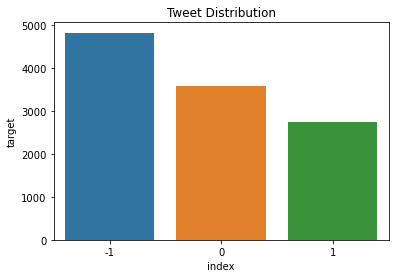

In [14]:
target_count = data_clean['target'].value_counts().reset_index()
ax = sns.barplot(x=target_count['index'], y=target_count['target'])
plt.title("Tweet Distribution")
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           2774600   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
Total params: 3,096,003
Trainable params: 321,403
Non-trainable params: 2,774,600
_________________________________________________________________
None
Epoch 1/50
56/56 [==============================] - 12s 222ms/step - loss: 31.4384 - accuracy: 0.4413 - val_loss: 7.1522 - val_accuracy: 0.4654
Epoch 2/50
56/56 [==============================] - 11s 195ms/step - loss: 2.5339 - accur

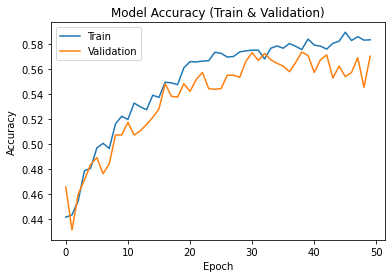

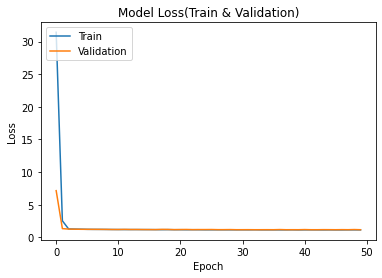

Test data evaluation
70/70 [==============================] - 2s 33ms/step - loss: 1.1832 - accuracy: 0.5517
Ytest 
-1    963
 0    715
 1    546
Name: target, dtype: int64
Pred 
-1    1032
 0     675
 1     517
dtype: int64
[[626 225 112]
 [247 332 136]
 [159 118 269]]
              precision    recall  f1-score   support

          -1       0.61      0.65      0.63       963
           0       0.49      0.46      0.48       715
           1       0.52      0.49      0.51       546

    accuracy                           0.55      2224
   macro avg       0.54      0.54      0.54      2224
weighted avg       0.55      0.55      0.55      2224



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


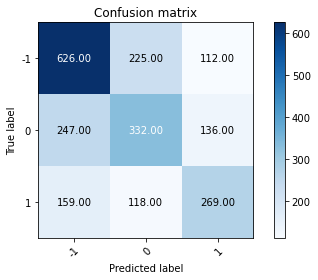

In [15]:
model_lstm,lstm_pred_labels = train_evaluate_model(data=data_clean ,model_type='lstm',
                                  input_length=50, epochs=50, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           2774600   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200)               80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 2,855,403
Trainable params: 80,803
Non-trainable params: 2,774,600
_________________________________________________________________
None
Epoch 1/50
56/56 [==============================] - 5s 82ms/step - loss: 17.6423 - accuracy: 0.4322 - val_loss: 9.0936 - val_accuracy: 0.4441
Epoch 2/50
56/56 [==============================] - 4s 78ms/step - loss: 4.6578 - accuracy

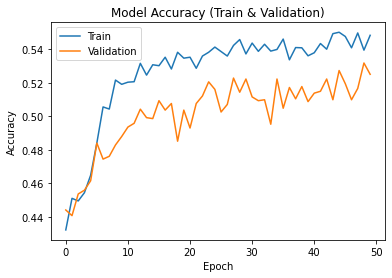

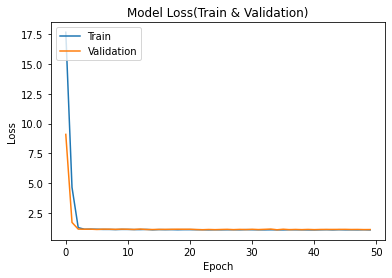

Test data evaluation
70/70 [==============================] - 1s 10ms/step - loss: 1.1328 - accuracy: 0.5351
Ytest 
-1    963
 0    715
 1    546
Name: target, dtype: int64
Pred 
-1    1256
 0     507
 1     461
dtype: int64
[[727 149  87]
 [354 225 136]
 [175 133 238]]
              precision    recall  f1-score   support

          -1       0.58      0.75      0.66       963
           0       0.44      0.31      0.37       715
           1       0.52      0.44      0.47       546

    accuracy                           0.54      2224
   macro avg       0.51      0.50      0.50      2224
weighted avg       0.52      0.54      0.52      2224



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


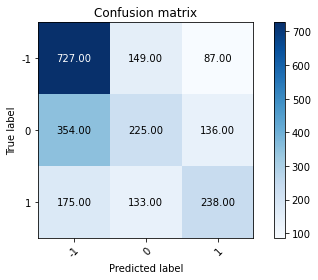

In [16]:
model_rnn,rnn_pred_labels = train_evaluate_model(data=data_clean , model_type='rnn',
                                  input_length=50, epochs=50, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 200)           2746800   
_________________________________________________________________
gru (GRU)                    (None, 200)               241200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 2,988,603
Trainable params: 241,803
Non-trainable params: 2,746,800
_________________________________________________________________
None
Epoch 1/50
56/56 [==============================] - 10s 173ms/step - loss: 28.9336 - accuracy: 0.4412 - val_loss: 8.6730 - val_accuracy: 0.4632
Epoch 2/50
56/56 [==============================] - 9s 154ms/step - loss: 3.0751 - accu

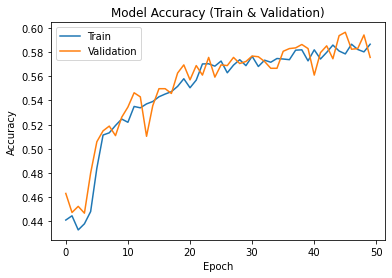

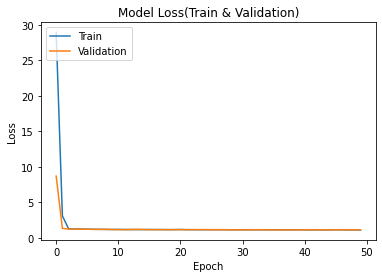

Test data evaluation
70/70 [==============================] - 2s 24ms/step - loss: 1.1582 - accuracy: 0.5495
Ytest 
-1    963
 0    715
 1    546
Name: target, dtype: int64
Pred 
-1    1034
 0     631
 1     559
dtype: int64
[[638 204 121]
 [257 302 156]
 [139 125 282]]
              precision    recall  f1-score   support

          -1       0.62      0.66      0.64       963
           0       0.48      0.42      0.45       715
           1       0.50      0.52      0.51       546

    accuracy                           0.55      2224
   macro avg       0.53      0.53      0.53      2224
weighted avg       0.54      0.55      0.55      2224



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


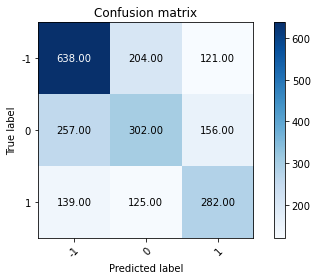

In [17]:
model_gru,gru_pred_labels = train_evaluate_model(data=data_clean ,model_type='gru',
                                  input_length=50, epochs=50,learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 200)           2771000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1203      
Total params: 3,413,803
Trainable params: 642,803
Non-trainable params: 2,771,000
_________________________________________________________________
None
Epoch 1/50
56/56 [==============================] - 20s 352ms/step - loss: 62.0951 - accuracy: 0.4460 - val_loss: 13.2252 - val_accuracy: 0.4441
Epoch 2/50
56/56 [==============================] - 19s 334ms/step - loss: 3.9945 - ac

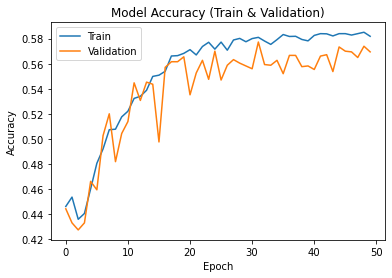

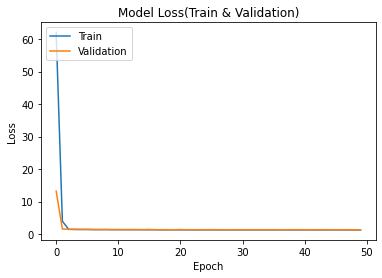

Test data evaluation
70/70 [==============================] - 3s 40ms/step - loss: 1.3267 - accuracy: 0.5629
Ytest 
-1    963
 0    715
 1    546
Name: target, dtype: int64
Pred 
-1    1202
 0     670
 1     352
dtype: int64
[[719 187  57]
 [317 318  80]
 [166 165 215]]
              precision    recall  f1-score   support

          -1       0.60      0.75      0.66       963
           0       0.47      0.44      0.46       715
           1       0.61      0.39      0.48       546

    accuracy                           0.56      2224
   macro avg       0.56      0.53      0.53      2224
weighted avg       0.56      0.56      0.55      2224



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


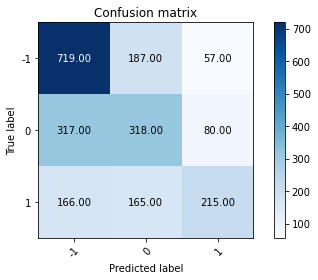

In [18]:
model_bilstm,bilstm_pred_labels = train_evaluate_model(data=data_clean , model_type='bilstm',
                                  input_length=50, epochs=50,learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)